#Data 

In [ ]:
#Import data
import json
import pandas as pd
import re
import string
from operator import attrgetter
import numpy as np
import copy
from itertools import combinations, product
import random
from scipy.special import binom
with open('/content/drive/MyDrive/Colab Notebooks/Data/Computer Science for Business Analytics/TVs-all-merged.json') as json_file:
    data = json.load(json_file)


##Data cleaning & Feature Engineering

In [ ]:
# pre-process the product descriptions by removing all common characters like comma’s, slashes, and white space and lowercase.
def preProcessTV(TV):
  newTV = TV.copy()
  title = TV['title']
  featuresMap = TV['featuresMap']
  
  # Remove shop from title
  title = preProcessTitle(title)
  newTV['title'] = title

  featuresMap = {preProcess(k): preProcess(transformPR(v)) for k,v in featuresMap.items()}
  newTV['featuresMap'] = featuresMap
  return newTV

def preProcessTitle(title: str):
  mappingSellers = [('Best Buy',''),('Newegg.com','')]
  modelWordsAfterSellerTrans = transformFrequentRepresentations(mappingSellers, title)
  title = transformPR(modelWordsAfterSellerTrans)
  title = preProcess(title)

  return title

def transformFrequentRepresentations(mapping, my_string):
  for k, v in mapping:
    my_string = my_string.replace(k, v)
  return my_string

def transformPR(string: str):
  mappingInch = [('Inch', 'inch'), ('inches', 'inch'), ('"', 'inch'), (' inch', 'inch'), ('-inch', 'inch'),('inch','')]
  mappingHertz = [('Hertz', 'hz'), ('hertz', 'hz'), ('HZ', 'hz'), ('-hz', 'hz'),('hz','')]

  valueAfterInchTransformation = transformFrequentRepresentations(mappingInch, string)
  valueAfterHertzTransformation = transformFrequentRepresentations(mappingHertz, valueAfterInchTransformation)
  return valueAfterHertzTransformation

def preProcess(text: str):
  textLowered = text.lower()
  mappingUselessWords = [('refurbished',''),('refurb',''),('open box',''),('diagonal',''),('diag',''),('class',''),('model','')]
  text = transformFrequentRepresentations(mappingUselessWords, textLowered)
  text = valueWithoutExtraSpaces = re.sub('\s{2,}'," ",text)
  textWithoutNonAlphanumericTokens = re.sub('[\W]','',text)
  return textWithoutNonAlphanumericTokens


##Train and test data

In [ ]:
def getTrainAndTestData(data, trainingSplit):
  tvIDs = data.keys()
  
  totalUniqueTVs = len(data.keys())
  trainingIDs = getModelIDsForTrain(data, trainingSplit)
  testingIDs = list(set(tvIDs).difference(set(trainingIDs)))

  train = getDataSplitWithModelIDs(data, trainingIDs)
  # test = getDataSplitWithModelIDs(data, testingIDs)
  test ={}
  return (train, test)

def getModelIDsForTrain(data, trainingSplit):
  tvIDs = data.keys()
  numberOfTVs = np.sum([ 1 for ModelID in tvIDs for TV in data[ModelID]])

  trainingSizeTarg = int(numberOfTVs * trainingSplit)
  trainingSizeCurr = 0
  trainingIDs = []

  while(trainingSizeCurr <= trainingSizeTarg):
    ModelID = random.choice(list(tvIDs))
    TVContainer = data[ModelID]
    trainingIDs.append(ModelID)
    for TV in TVContainer:
      trainingSizeCurr +=1
  return trainingIDs

def getDataSplitWithModelIDs(data, modelIDs: list):
  dataSplit = {
      'TVs': [],
      'duplicates': []
  }

  TVCounter = 0
  s = []
  for idx, modelId in enumerate(modelIDs):
    TVs = dataSplit['TVs']
    duplicates = dataSplit['duplicates']
      
    currentTVContainer = data[modelId]
    idxOfTVsInContainer = []
    # print(len(currentTVContainer))
    for TV in currentTVContainer:
      
      s.append(TV)
      CleanTV = preProcessTV(TV)
      TVs.append(CleanTV.copy()) 

      idxOfTVsInContainer.append(TVCounter)
      TVCounter +=1

    # Saving real duplicates 
    if(len(idxOfTVsInContainer) > 1):
      duplicates.extend(combinations(idxOfTVsInContainer,2))
    # print(idxOfTVsInContainer)
    # print('\n')
  print(len(s))
  

  return dataSplit





##ModelWordsExtractor

In [ ]:
class ModelWordsExtractor: 
  def getModelWordsFromFeatMap(self, featMap):
    mwsList = []
    for key, value in featMap.items():
      mws = self.getModelWords(value)
      for mw in mws: 
        mwsList.append(mw)
    return set(mwsList)

  def getModelWords(self, value):
    return set(re.findall('\w+',valueWithoutExtraSpaces))
  
  def getSetFromRe(self, reResult):
    setFromRe =  { modelWord for modelWorldTuple in reResult for modelWord in modelWorldTuple}
    removedWhiteSpace = {  re.sub(r'[\s]',"",modelWord) for modelWord in setFromRe if re.sub(r'[\s]',"",modelWord)!=''}
    return removedWhiteSpace

##Qgrams

In [ ]:
class Qgrams: 
  def __init__(self, QgramsSize):
    self.QgramsSize = QgramsSize

  def getSimilUsingQgrams(self, string1: str, string2: str):
      # print(string1)
      # print(string2)
      Qgram1 = self.buildQgrams(string1)
      Qgram2 = self.buildQgrams(string2)
      simil = self.getQgramSimil(Qgram1,Qgram2)
      return simil
 
  def buildQgrams(self, sentence: str):
    k = self.QgramsSize
    qgrams = []
    prefix = "".join(['#' * (k-1)])
    suffix = "".join(['%' * (k-1)])
    sentence = prefix + sentence + suffix
    for i in range(len(sentence) - (k-1)):
      qgrams.append(sentence[i:i+k])
    return set(qgrams)

  def jaccard(self, setOne: set, setTwo: set):
    return len(setOne.intersection(setTwo)) / len(setOne.union(setTwo))

  def getQgramSimil(self, qgram1, qgram2):
    n1 = len(qgram1)
    n2 = len(qgram2)
    QgramDist = len(qgram1.union(qgram2)) - len(qgram1.intersection(qgram2))
    return (n1 + n2 - QgramDist) / (n1 + n2)


#LSH


##Shingling & Encoding

In [ ]:
def buildShingles(sentence: str, k: int):
    shingles = []
    for i in range(len(sentence) - k):
      shingles.append(sentence[i:i+k])
    return set(shingles)

def getShinglesFromTitle(TVTitle: str):  
  shingles = re.sub('['+string.punctuation+']', '', TVTitle).split()
  return(set(shingles))

def getTitleWithoutPunctuation(TVTitle: str):
  return re.sub('['+string.punctuation+']', '', TVTitle)

def buildVocab(shingleSets: list):
  fullSet = {item for shingleSet in shingleSets for item in shingleSet}
  vocab = {}
  for i, shingle in enumerate(list(fullSet)):
    vocab[shingle] = i
  return vocab

def oneHotEncode(shingles: set, vocab: dict):
  vect = np.zeros(len(vocab))
  for shingle in shingles:
    idx = vocab[shingle]
    vect[idx]=1
  return vect


##Get shingle matrix from TVs

In [ ]:
# Creating shingles from qgrams and building vocabulary
##Create qgrams from title and featmap values and use those to make a shingle set

def getShinglesFromTVsAndVocab(TVs, QgramsSize):
  QG = Qgrams(QgramsSize)
  TVShingles = []
  for TV in TVs:
    titleShingles = buildShingles(TV['title'],QgramsSize)
    TVShingles.append(titleShingles)
  
  vocab = buildVocab(TVShingles)

  shinglesOneHot = []
  for shingleSet in TVShingles:
    shinglesOneHot.append(oneHotEncode(shingleSet, vocab))

  # stack into single numpy array
  shinglesOneHot = np.stack(shinglesOneHot)
  print(f'Shape of shingleMatrix {shinglesOneHot.shape}')
  return (shinglesOneHot, vocab)


def getShingleSetFromFeatMap(featMap, QgramsSize):
  QG = Qgrams(QgramsSize)
  shingleList = [ QG.buildQgrams(featMap[key]) for key in featMap.keys()]
  shingleSet = { qgram for qgramSet in shingleList for qgram in qgramSet}
  return shingleSet

##Min-Hashing

In [ ]:
def getMinhashFuncsArray(vocab: dict, nFuncs: int):
    length = len(vocab.keys())
    arr = np.zeros((nFuncs, length))
    for i in range(nFuncs):
        permutation = np.random.permutation(len(vocab)) + 1
        arr[i, :] = permutation.copy()
    return arr.astype(int)

def getSignature(minhashFuncsArray, oneHotVec):
    # get index locations of every nonzero value in one hot encoded vector
    idx = np.nonzero(oneHotVec)[0].tolist()
 
    # get values of the non zero indices for every hash function
    shingles = minhashFuncsArray[:, idx]
    
    # find minimum value for each hash function where index was one
    signature = np.min(shingles, axis=1)
    return signature

def getSignatureMatrix(shinglesOneHotMatrix, lenSignature:int, vocab: dict):
  minHashFuncsArray = getMinhashFuncsArray(vocab, lenSignature)
  signatures = []

  for oneHotVec in shinglesOneHotMatrix:
    signatures.append(getSignature(minHashFuncsArray, oneHotVec))
  
  # merge signatures into single array
  signatures = np.stack(signatures)
  print(f'This is the shape of the signature matrix: {signatures.shape}')
  return signatures

##LSH process

In [ ]:
class LSH:
    buckets = []
    indexSignature = 0

    def __init__(self, b):
        self.b = b
        for i in range(b):
            self.buckets.append({})

    def makeSubvecs(self, signature):
        l = len(signature)
        assert l % self.b == 0
        r = int(l / self.b)
        # break signature into subvectors
        subvecs = []
        for i in range(0, l, r):
            subvecs.append(signature[i:i+r])
        return np.stack(subvecs)
       
    def addSignatureToBuckets(self, signature):
      bandsOfSignature = self.makeSubvecs(signature).astype(str)
      for bandIndex, bandOfSignature in enumerate(bandsOfSignature):
        # From subvec of signature create a key to store in bands dictionary
        bandSigValuesAsKey = ",".join(bandOfSignature)

        # If subvec key of signature signatureIndex does not exists in dictionary for band i add it to dictionary
        if bandSigValuesAsKey not in self.buckets[bandIndex].keys():
          self.buckets[bandIndex][bandSigValuesAsKey] = []
        
        #Add index of signature to its subvec signature key in band dictionary, if another signature has the same key for this band then both indices are represented as value of key
        self.buckets[bandIndex][bandSigValuesAsKey].append(self.indexSignature)
      self.indexSignature +=1

    def checkCandidates(self):
        candidates = []
        for bucketBand in self.buckets:
            # All unique sub signatures in a bucket band
            keys = bucketBand.keys()
            for bucket in keys:
                nSubSigsThatShareBucket = bucketBand[bucket]
                if len(nSubSigsThatShareBucket) > 1:
                    # Get all possible pairs of sub signatures that share bucket band
                    candidates.extend(combinations(nSubSigsThatShareBucket, 2))
        # Return non duplicate pairs of sub signatures that share bucket band
        return set(candidates)
    
    def reset(self):
      self.buckets = []
      self.indexSignature = 0
      for i in range(self.b):
        self.buckets.append({})

#

#Evaluation

In [ ]:
class Evaluator: 
  yTrue = []
  def __init__(self, yPred: list, duplicates: list, candidates: list, totalTVs: int):
    self.yTrue = [True if candidate in duplicates else False for candidate in candidates]
    self.yPred = yPred
    self.nComparisons = len(candidates)
    assert len(self.yPred) == len(self.yTrue), 'Uneven lengths'
    self.duplicates = duplicates
    self.candidates = candidates
    self.nDupesFound = np.sum([1 for candidate in self.candidates if candidate in self.duplicates])
    self.totalTVs = totalTVs
    print(f'number of dupes found: {self.nDupesFound}')
    print(f'number of dupes total: {len( self.duplicates)}')

  def getPairQuality(self):
    return self.nDupesFound / self.nComparisons

  def getPairCompleteness(self):
    return self.nDupesFound / len(self.duplicates)
  
  def F1_score_star(self):
    pairQuality = self.getPairQuality()
    pairCompleteness = self.getPairCompleteness()
    return 2 * ( pairQuality * pairCompleteness ) / (pairQuality + pairCompleteness)

  def F1_score_classifier(self):
    return f1_score(self.yTrue, self.yPred)
  
  def reset(self):
    yTrue = []

  def getFractionsOfComparisons(self):
    possibleComparisons = self.totalTVs * (self.totalTVs - 1) /2
    print(f'possibleComparisons: {possibleComparisons}')
    print(f'comparisons made: {self.nComparisons}')
    return self.nComparisons / possibleComparisons

  def getLSHPerformance(self):
    pairQuality = self.getPairQuality()
    pairCompleteness = self.getPairCompleteness()
    F1_score_star = self.F1_score_star()
    fractionsOfComparisons = self.getFractionsOfComparisons()

    print(f'Pair quality: {pairQuality} \n')
    print(f'Pair completeness: {pairCompleteness} \n')
    print(f'F1*: {F1_score_star} \n')
    print(f'Fraction of comparisons: {fractionsOfComparisons}')
    return {
        'pairQuality':pairQuality,
        'pairCompleteness':pairCompleteness,
        'F1_score_star':F1_score_star,
        'fractionsOfComparisons':round(fractionsOfComparisons,2)
    }
    


#Main


##Band numbers

In [ ]:
viableBandNumbers504 = [4, 6, 7, 8, 9, 12, 14, 18, 21, 24, 28, 36, 42, 56, 63, 72, 84, 126, 168, 252, 504]
viableBandNumbers480 = [4, 10, 20, 24, 30, 32, 40, 48, 60, 80, 96, 120, 160, 240]
viableBnads330 = [1, 2, 3, 5, 6, 10, 11, 15, 22, 30, 33, 55, 66, 110, 165, 330]
viableBands1500 = [1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 25, 30, 50, 60, 75, 100, 125, 150, 250, 300, 375, 500, 750]

##Bootstrap

In [ ]:
results = []
for bootstrap in range(100):
  print(f'*** \n CURRENT BOOTSTRAP: {bootstrap} \n ****')
  qGramSize = 3
  nHashFuncs = 330
  for b in viableBnads330:
    print(f'\n b is equal to {b}')
    print(f'The amount of rows in a band is equal to {int(nHashFuncs / b)}')
    train, test = getTrainAndTestData(data, 0.6)
    (shinglesOneHot, vocab) = getShinglesFromTVsAndVocab(train['TVs'], qGramSize)

    lsh = LSH(b)
    lsh.reset()
  
    signatures = getSignatureMatrix(shinglesOneHot, nHashFuncs, vocab)
    for signature in signatures:
      lsh.addSignatureToBuckets(signature)

    candidates = lsh.checkCandidates()
    print(f'The amount of candidates is equal to {len(lsh.checkCandidates())}')
    nTVs = len(train['TVs'])
    evaluator = Evaluator([27 for i in range(len(candidates))], train['duplicates'], candidates, nTVs)
    results.append(evaluator.getLSHPerformance())  
  
  nHashFuncs = 480
  for b in viableBandNumbers480:
    print(f'\n b is equal to {b}')
    print(f'The amount of rows in a band is equal to {int(nHashFuncs / b)}')
    train, test = getTrainAndTestData(data, 0.6)
    (shinglesOneHot, vocab) = getShinglesFromTVsAndVocab(train['TVs'], qGramSize)

    lsh = LSH(b)
    lsh.reset()
  
    signatures = getSignatureMatrix(shinglesOneHot, nHashFuncs, vocab)
    for signature in signatures:
      lsh.addSignatureToBuckets(signature)

    candidates = lsh.checkCandidates()
    print(f'The amount of candidates is equal to {len(lsh.checkCandidates())}')
    nTVs = len(train['TVs'])
    evaluator = Evaluator([27 for i in range(len(candidates))], train['duplicates'], candidates, nTVs)
    results.append(evaluator.getLSHPerformance())  


In [ ]:
import math
import numpy as np
# Sort results to fraction of comparisons
pairComplet = {}
for result in results:
  fracOfComparisons = result['fractionsOfComparisons']
  fracOfComparisons = str(round(fracOfComparisons,2))
  if(fracOfComparisons in pairComplet.keys()):
    pairComplet[fracOfComparisons].append( (result['F1_score_star'], result['pairCompleteness'], result['pairQuality']) )
  else: 
    pairComplet[fracOfComparisons] = []
    pairComplet[fracOfComparisons].append( (result['F1_score_star'], result['pairCompleteness'], result['pairQuality']))

# Average obs for every fraction of comparison
xaxis = []
graph_data = []
for fracOfComparison in sorted(pairComplet.keys()):
  resultsContainer = pairComplet[fracOfComparison]

  avgScore = np.zeros((len(resultsContainer[0]),))
  resultsCounter = 0
  for f1_score, pairCompleteness, pairQuality in resultsContainer:
    if(math.isnan(f1_score) == False):
      avgScore += np.array([f1_score, pairCompleteness, pairQuality])
      resultsCounter +=1
  print(f'for fractionOfComparisions: {float(fracOfComparison)}: {avgScore / resultsCounter}')
  graph_data.append(avgScore / resultsCounter)
  xaxis.append(float(fracOfComparison))
np_graph_data = np.array(graph_data)
    

Text(0, 0.5, 'Pair Completeness')

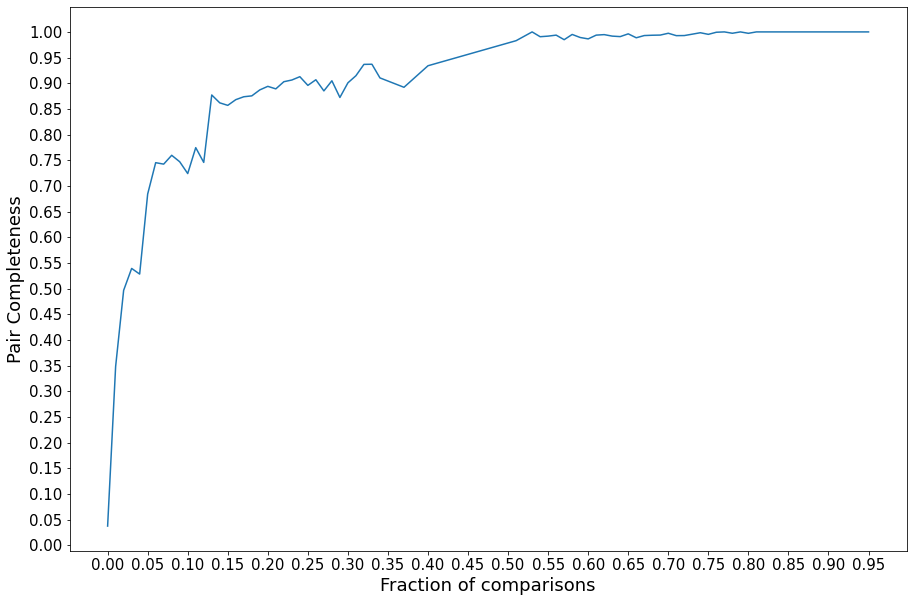

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
plt.xticks(np.arange(0,1.01,0.05), fontsize=15)

plt.yticks(np.arange(0,1.01,0.05),fontsize=15)
plt.plot(xaxis, np_graph_data[:,1])
plt.xlabel("Fraction of comparisons", fontsize=18)
plt.ylabel("Pair Completeness",fontsize=18)
